In [2]:
import math
%pip install numpy
%pip install tensorflow-macos
%pip install networkx
%pip install matplotlib
%pip install pydot
%pip install scipy
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from keras.applications import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
from typing import List, Tuple, Dict
from tensorflow.python.framework.convert_to_constants import (
    convert_variables_to_constants_v2_as_graph,
)
from IPython.utils import io
import pandas as pd
import networkx as nx
from bidict import bidict
import elkai
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
class Partitioner:
    def __init__(self, model: keras.Model):
        self.model = model
        self.Stack = []
        self.visited = {}
        # The "depth"/level that a certain layer is at
        self.layer_level = {}
        # The layers at a certain depth/level, where the index of the array is the level
        self.levels = []

    def get_previous(self, layer_name):
        inbound = self.model.get_layer(layer_name).inbound_nodes[0].inbound_layers
        if type(inbound) != list:
            inbound = [inbound]
        return [layer.name for layer in inbound]

    def get_next(self, layer_name):
        outbound = self.model.get_layer(layer_name).outbound_nodes
        return [node.outbound_layer.name for node in outbound]

    # Traverses the model starting from layer_name all the way to start
    def traverse(self, layer_name, start, part_name, inpt):
        # On subsequent recursive steps, the new input layer will be defined,
        # so that name needs to be checked in base case
        if (layer_name == start) or (layer_name == part_name):
            return inpt

        output = []
        for n in self.get_previous(layer_name):
            output.append(self.traverse(n, start, part_name, inpt))

        # If the DAG node only has 1 previous connection
        if len(output) == 1:
            output = output[0]

        layer = self.model.get_layer(layer_name)
        to_next = layer(output)
        return to_next

    def construct_model(self, start, end, part_name="part_begin"):
        inpt = keras.Input(tensor=self.model.get_layer(start).output, name=part_name)
        output = self.traverse(end, start, part_name, inpt)
        part = keras.Model(inputs=self.model.get_layer(start).output, outputs=output)
        return part

    # TODO write this function
    def create_model_partitions(self, node_capacities: List[str], communication_graph: nx.Graph):
        node_partition_names = self.partition_model(node_capacities, communication_graph)
        model_partitions = {}
        for k in node_partition_names:
            start_layer, end_layer = node_partition_names[k]
            model = self.construct_model(start_layer, end_layer)
            model_partitions[k] = model
            print("Model constructed")

        return model_partitions


    # A recursive function used by longest_path. See below
    # link for details
    # https:#www.geeksforgeeks.org/topological-sorting/
    def topological_sort_util(self, v: str):
        self.visited[v] = True

        # Recur for all the vertices adjacent to this vertex
        # list<AdjListNode>::iterator i
        for i in self.get_next(v):
            if not self.visited[i]:
                self.topological_sort_util(i)

        # Push current vertex to stack which stores topological
        # sort
        self.Stack.append(v)

    # The function to find longest distances from a given vertex.
    # It uses recursive topologicalSortUtil() to get topological
    # sorting.
    def longest_path(self, s: str) -> List[List[str]]:
        for l in self.model.layers:
            self.visited[l.name] = False
            self.layer_level[l.name] = -1 # Equal to -infty

        # Call the recursive helper function to store Topological
        # Sort starting from all vertices one by one
        for l in self.model.layers:
            if not self.visited[l.name]:
                self.topological_sort_util(l.name)

        # Initialize distances to all vertices as infinite and
        # distance to source as 0
        self.layer_level[s] = 0

        # Process vertices in topological order
        while len(self.Stack) > 0:

            # Get the next vertex from topological order
            u = self.Stack.pop()

            # Update distances of all adjacent vertices
            # list<AdjListNode>::iterator i
            if self.layer_level[u] != -1:
                for i in self.get_next(u):
                    if self.layer_level[i] < self.layer_level[u] + 1:
                        self.layer_level[i] = self.layer_level[u] + 1 # Each edge weighted 1

        # Create array of calculated longest distances to layer
        layers_at_level = [[]] * len(self.layer_level)
        for l in self.model.layers:
            if len(layers_at_level[self.layer_level[l.name]]) == 0:
                layers_at_level[self.layer_level[l.name]] = []

            layers_at_level[self.layer_level[l.name]].append(l.name)

        return layers_at_level

    def find_singletons(self):
        # Model only has 1 input, which is input_names[0]
        name = self.model.input_names[0]
        # Finding the longest path from the start to every other layer
        self.levels = self.longest_path(name)
        singletons = []
        for l in range(len(self.levels)):
            if len(self.levels[l]) == 1:
                singletons.append(self.levels[l][0])
        return singletons

    def find_all_paths_util(self, u, d, visited, path, all_paths):
        # If the distance of the current path is greater than the longest path (the "level") to the destination node, we know the destination node can't be a partition point
        if self.layer_level[u] > self.layer_level[d]:
            return False
        # Mark the current node as visited and store in path
        visited[u] = True
        path.append(u)

        # If current vertex is same as destination, then print
        # current path[] (because we've found a path from u to d)
        if u == d:
            exists = False
            # See if path already exists in list of paths
            for p in all_paths:
                if p == path:
                    exists = True
                    break

            if not exists:
                all_paths.append(path.copy())
        else:
            # If current vertex is not destination
            # Recur for all the vertices adjacent to this vertex
            for i in self.get_next(u):
                if not visited[i]:
                    ret = self.find_all_paths_util(i, d, visited, path, all_paths)
                    if not ret:
                        return False

        # Remove current vertex from path[] and mark it as unvisited
        path.pop()
        visited[u] = False
        return True

    # Finds all paths from 's' to 'd.' Returns false if a there exists a path from s that has a greater "level" than d, otherwise returns true
    def find_all_paths(self, s, d) -> bool:
        # Mark all the vertices as not visited
        visited = {}
        for l in self.model.layers:
            visited[l.name] = False

        # Create an array to store paths
        path = []
        all_paths = []

        # Call the recursive helper function to find all paths
        return self.find_all_paths_util(s, d, visited, path, all_paths)

    def partitions_util(self, prev, singleton_nodes, partitions):
        # Reached the end of the model and found all the partitions
        if len(singleton_nodes) == 0:
            return partitions
        p = False
        i = -1 # So first i starts at 0
        # Starting from the previous partition point, we iterate through all the subsequent singleton nodes to find the next partition point
        while not p:
            i += 1
            p = self.find_all_paths(prev, singleton_nodes[i])

        partitions.append(singleton_nodes[i])
        return self.partitions_util(singleton_nodes[i], singleton_nodes[i + 1:], partitions)

    def find_partitions(self) -> List[str]:
        inpt = self.model.input_names[0]
        return self.partitions_util(inpt, self.find_singletons(), [])

    def keras_model_memory_usage_in_bytes(self, model, batch_size: int):
        """
        Return the estimated memory usage of a given Keras model in bytes.
        This includes the model weights and layers, but excludes the dataset.

        The model shapes are multiplied by the batch size, but the weights are not.

        Args:
            model: A Keras model.
            batch_size: The batch size you intend to run the model with. If you
                have already specified the batch size in the model itself, then
                pass `1` as the argument here.
        Returns:
            An estimate of the Keras model's memory usage in bytes.

        """
        default_dtype = tf.keras.backend.floatx()
        shapes_mem_count = 0
        internal_model_mem_count = 0
        for layer in model.layers:
            if isinstance(layer, tf.keras.Model):
                internal_model_mem_count += self.keras_model_memory_usage_in_bytes(
                    layer, batch_size=batch_size
                )
            single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
            out_shape = layer.output_shape
            if isinstance(out_shape, list):
                out_shape = out_shape[0]
            for s in out_shape:
                if s is None:
                    continue
                single_layer_mem *= s
            shapes_mem_count += single_layer_mem

        trainable_count = sum(
            [tf.keras.backend.count_params(p) for p in model.trainable_weights]
        )
        non_trainable_count = sum(
            [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
        )

        total_memory = (
                batch_size * shapes_mem_count
                + internal_model_mem_count
                + trainable_count
                + non_trainable_count
        )
        return total_memory

    def keras_layer_memory(self, layer_name, batch_size: int):
        default_dtype = tf.keras.backend.floatx()
        shapes_mem_count = 0
        internal_model_mem_count = 0

        if isinstance(layer_name, tf.keras.Model):
            internal_model_mem_count += self.keras_model_memory_usage_in_bytes(
                layer_name, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer_name.dtype or default_dtype).size
        out_shape = layer_name.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

        trainable_count = sum(
            [tf.keras.backend.count_params(p) for p in layer_name.trainable_weights]
        )
        non_trainable_count = sum(
            [tf.keras.backend.count_params(p) for p in layer_name.non_trainable_weights]
        )

        total_memory = (
                batch_size * shapes_mem_count
                + internal_model_mem_count
                + trainable_count
                + non_trainable_count
        )
        return total_memory

    def find_partition_memory(self, partition_points):
        part_mems = []
        for i in range(1, len(partition_points)):
            # Going backwards along layers within partition to find total memory usage
            start = self.layer_level[partition_points[i]]
            end = self.layer_level[partition_points[i - 1]]
            mem = 0
            for j in range(start, end, -1):
                for l in self.levels[j]:
                    layer_mem = self.keras_layer_memory(self.model.get_layer(l), 1)
                    mem += layer_mem
            part_mems.append(mem)
        return part_mems

    # Returns transfer size of partition in Mbits
    def find_partition_transfer_size(self, partition_points) -> Tuple[List[int], Dict[str, int]]:
        transfer_sizes = []
        transfer_size_dict = {}
        for i in range(1, len(partition_points)):
            num_outbound = len(self.model.get_layer(partition_points[i]).outbound_nodes)

            # Iterate through all elements of shape tuple except first one (which is batch size)
            output_size = 1
            for s in self.model.get_layer(partition_points[i]).get_output_at(0).get_shape()[1:]:
                output_size *= s
            # Compression ratio is ~1.44 (according to https://www.researchgate.net/publication/264417607_Fixed-Rate_Compressed_Floating-Point_Arrays)
            zfp_comp_ratio = 1.44
            # Assuming all elements are floats, each float uses 8 bytes
            output_size_bytes = (output_size * 8) / zfp_comp_ratio
            output_size_bits = (output_size_bytes * 8) / (1024 ** 2)
            # All outputs of the layer are the same size, the total size will be (output size * num_output_nodes)
            transfer_size = num_outbound * output_size_bits
            transfer_size_dict[partition_points[i]] = transfer_size
            transfer_sizes.append(transfer_size)

        return transfer_sizes, transfer_size_dict

    # For each node, finds the next partition point with the smallest transfer size
    def partition_model(self, node_capacities: List[int], communication_graph: nx.Graph) -> Dict[str, Tuple[str, str]]:
        parts = self.find_partitions()
        part_mems = self.find_partition_memory(parts)
        part_transfer_size, transfer_size_dict = self.find_partition_transfer_size(parts)

        min_cap_per_node = node_capacities[0] / len(node_capacities)
        models = []
        prev_partition_point = 0
        for c in range(len(node_capacities)):
            # We've partitioned the model in less physical nodes than we have
            if prev_partition_point > len(part_mems) - 1:
                break
            p = prev_partition_point
            min_data_size = part_transfer_size[p]
            min_data_size_ind = p
            while sum(part_mems[prev_partition_point : p]) < node_capacities[c]:
                # divide node capacity by number of nodes, and make sure that each node has at least that amount of capacity, to make sure we fit the model into the nodes
                if part_transfer_size[p] < min_data_size and sum(part_mems[prev_partition_point : p]) > min_cap_per_node:
                    min_data_size = part_transfer_size[p]
                    min_data_size_ind = p
                # End of partition points
                if p == len(part_mems) - 1:
                    break
                p += 1
            min_data_size_partition_pt = parts[min_data_size_ind + 1]
            models.append((parts[prev_partition_point + 1], min_data_size_partition_pt))

            # The "+1" is so that the next partition starts at the layer after the previous partition
            prev_partition_point = min_data_size_ind + 1

        # The first partition should start from the input layer
        models[0] = (parts[0], models[0][1])
        # The last partition should end with the output layer
        models[-1] = (models[-1][0], parts[-1])

        # If the last partition fits into the node, we know we've partitioned successfully
        if sum(part_mems[parts.index(models[-1][0]):]) <= node_capacities[-1]:
            print("Model successfully partitioned")
        else:
            raise MemoryError("Model not partitioned successfully")

        btsp = BTSP(communication_graph)
        node_tour = btsp.btsp_binary_search()

        # At the end, we need to "shift" the partitions across all remaining nodes in the BTSP if we have extra nodes, to see if we can come up with a lower bottleneck value (find the lowest bottleneck of (transfer size / bandwidth)
        tries_for_shifting = len(node_tour) - len(models) + 1
        best_try = 0
        smallest_latency = math.inf
        for i in range(tries_for_shifting):
            bottleneck_latency = 0
            for j in range(len(models) - 1):
                transfer_layer = models[j][1]
                transfer_size = transfer_size_dict[transfer_layer]
                # Inv bandwidth = 1 / bandwidth
                inv_bandwidth = communication_graph[node_tour[j + i]][node_tour[(j+i) + 1]]['weight']
                curr_latency = transfer_size * inv_bandwidth
                if curr_latency > bottleneck_latency:
                    bottleneck_latency = curr_latency
            if bottleneck_latency < smallest_latency:
                best_try = i
                smallest_latency = bottleneck_latency

        partition_per_node = {}
        for k in range(len(models)):
            partition_per_node[node_tour[k + best_try]] = models[k]

        return partition_per_node

class BTSP:
    def __init__(self, g: nx.Graph):
        self.graph = g
        nodes = list(g)
        # Bidict mapping index in distance matrix row/column to name of node
        self.name_to_idx = bidict({nodes[i]:i for i in range(len(nodes))})
        self.num_nodes = len(nodes)

    def order_edge_weights(self):
        edges=sorted(self.graph.edges().data('weight'), key=lambda t: t[2])
        return edges

    # Zero/One Cost Matrix as used in http://www.cs.unb.ca/tech-reports/honours-theses/John.LaRusic-4997.pdf
    def build_cost_matrix(self, E, b: int):
        matrix = [[0] * self.num_nodes] * self.num_nodes
        for e in E:
            w = 1
            if e[2] <= b:
                w = 0
            matrix[self.name_to_idx[e[0]]][self.name_to_idx[e[1]]] = w

        return matrix

    # Returns the length of a tour given by an ordered list of vertices
    def get_tour_length(self, t: List[int], dist: List[List]):
        length = 0
        for i in range(len(t) - 1):
            length += dist[t[i]][t[i+1]]
        return length

    def btsp_binary_search(self) -> List[str]:
        E = self.order_edge_weights()
        low = 0
        high = len(E)
        best_tour = []
        while low < high:
            median = ((high - low) // 2) + low
            med_cost = E[median][2]
            D = self.build_cost_matrix(E, med_cost)
            tour = elkai.solve_int_matrix(D)
            length = self.get_tour_length(tour, D)
            if length == 0:
                high = median
                best_tour = tour
            else:
                low = median + 1

        tour_names = [self.name_to_idx.inverse[t] for t in best_tour]
        return tour_names

In [7]:
m = ResNet50()
layers = m.layers
all_transfers = []
for l in layers:
    num_outbound = len(m.get_layer(l.name).outbound_nodes)

    # Iterate through all elements of shape tuple except first one (which is batch size)
    output_size = 1
    for s in m.get_layer(l.name).get_output_at(0).get_shape()[1:]:
        output_size *= s
    # Compression ratio is ~1.44 (according to https://www.researchgate.net/publication/264417607_Fixed-Rate_Compressed_Floating-Point_Arrays)
    zfp_comp_ratio = 1.44
    # Assuming all elements are floats, each float uses 8 bytes
    output_size_bytes = (output_size * 8) / zfp_comp_ratio
    output_size_bits = (output_size_bytes * 8) / (1024 ** 2)
    # All outputs of the layer are the same size, the total size will be (output size * num_output_nodes)
    transfer_size = num_outbound * output_size_bits
    all_transfers.append(transfer_size)

avg = np.mean(np.array(all_transfers))
print(avg)

10.234529599407075


Model successfully partitioned
Model constructed
Model constructed
Model constructed
Model constructed
{'A': <keras.engine.functional.Functional object at 0x3024f0580>, 'F': <keras.engine.functional.Functional object at 0x301af2c40>, 'J': <keras.engine.functional.Functional object at 0x301b7b700>, 'C': <keras.engine.functional.Functional object at 0x303adb4f0>}


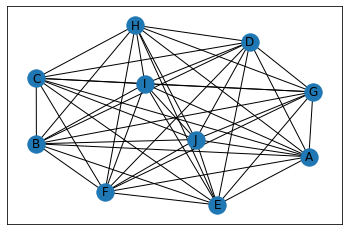

In [9]:
md = ResNet50()
partitioner = Partitioner(md)

num_nodes = 10
# TODO: When passing in a real-life graph, we need to convert from bandwidth to inverse bandwidth
communication_graph = nx.random_geometric_graph([chr(i) for i in range(ord('A'), ord('A') + num_nodes)], 2, dim=3, seed=5)
weighted_edges = []

# Returns bandwidth in Mbps
def distance_to_bandwidth(d):
    # Network with average bandwidth = 6.5 Mbps
    a = 283230
    return math.log2(1 + a / (d ** 2))

for j in communication_graph.edges:
    u = j[0]
    v = j[1]
    dist = scipy.spatial.distance.euclidean(communication_graph.nodes[u]["pos"], communication_graph.nodes[v]["pos"])
    w = distance_to_bandwidth(dist)
    inv_bandwidth = 1 / w
    weighted_edges.append((u, v, inv_bandwidth))
communication_graph.add_weighted_edges_from(weighted_edges)
nx.draw_networkx(communication_graph)

node_caps = [100 * (1024 ** 2)] * num_nodes
print(partitioner.create_model_partitions(node_caps, communication_graph))

In [3]:
# Getting the models from the module names
def get_models():
    modules = []
    models = []
    models_str = []
    for mod in dir(keras.applications):
        # If submodule name is uppercase, it is the class of a model and not a submodule
        if mod[0].isupper():
            modules.append(mod)
    for ms in modules:
        if 'MobileNet' in ms:
            model = eval(f"{ms}(input_shape=(224, 224, 3), weights=\'imagenet\')")
        elif 'NASNet' in ms:
            # Model architecture prevents from it being partitioned
           continue
        elif 'RegNet' in ms:
           model = eval(f"keras.applications.regnet.{ms}(weights=\'imagenet\')")
        else:
            model = eval(f"{ms}(weights=\'imagenet\')")
        models.append(model)
        models_str.append(ms)

    return models_str, models

models_str, models = get_models()

Metal device set to: Apple M1 Pro


2022-09-14 21:51:53.630406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-14 21:51:53.630543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#Calculating variance in CV for all Keras models
for m in range(len(models)):
    p = Partitioner(models[m])
    part_pts = p.find_partitions()
    transfer_sizes = p.find_partition_transfer_size(part_pts)[0]
    rng = np.ptp(transfer_sizes)
    print(f"{models_str[m]}\t{rng}")

DenseNet121	59.548611111111114
DenseNet169	59.548611111111114
DenseNet201	59.548611111111114
EfficientNetB0	51.95719401041667
EfficientNetB1	59.57438151041667
EfficientNetB2	69.82828776041667
EfficientNetB3	139.166259765625
EfficientNetB4	222.662353515625
EfficientNetB5	320.074462890625
EfficientNetB6	571.4925130208334
EfficientNetB7	737.3128255208334
EfficientNetV2B0	17.01388888888889
EfficientNetV2B1	19.53125
EfficientNetV2B2	22.92209201388889
EfficientNetV2B3	38.14697265625
EfficientNetV2L	156.25
EfficientNetV2M	117.1875
EfficientNetV2S	75.0
InceptionResNetV2	66.46050347222223
InceptionV3	59.814453125
MobileNet	34.63812934027778
MobileNetV2	51.95719401041667
MobileNetV3Large	34.63812934027778
MobileNetV3Small	17.01388888888889
RegNetX002	34.02777777777778
RegNetX004	34.02777777777778
RegNetX006	34.02777777777778
RegNetX008	34.02777777777778
RegNetX016	34.02777777777778
RegNetX032	34.02777777777778
RegNetX040	34.02777777777778
RegNetX064	44.661458333333336
RegNetX080	34.0277777777777

In [8]:
#https://github.com/tokusumi/keras-flops/blob/master/keras_flops/flops_calculation.py
def get_flops(model: keras.Model, batch_size=1) -> int:
    # convert tf.keras model into frozen graph to count FLOPS about operations used at inference
    # FLOPS depends on batch size
    inputs = [
        tf.TensorSpec([batch_size] + inp.shape[1:], inp.dtype) for inp in model.inputs
    ]
    real_model = tf.function(model).get_concrete_function(inputs)
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(real_model)

    # Calculate FLOPS with tf.profiler
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(
        graph=frozen_func.graph, run_meta=run_meta, cmd="scope", options=opts
    )

    return flops.total_float_ops

In [ ]:
# Calculating FLOPs and memory for models
model_stats = []
df = pd.DataFrame()
filename = 'last_parts.csv'
df.to_csv(filename)
#TODO figure out why we can't get flop count for RS350 and RS420
# Idx 58 is ResNetRS350
# Remember to save to new CSV when running from idx 58
for m in range(58, 60):
    model = models[m]
    model_name = models_str[m]
    p = Partitioner(model)
    with io.capture_output() as captured:
        flops = get_flops(model)
        mem = p.keras_model_memory_usage_in_bytes(model, 1)
    data = {"Name": [model_name], "FLOPs": [flops], "Memory": [mem]}
    data_df = pd.DataFrame(data)
    data_df.to_csv(filename, mode='a', index=False, header=False)

In [12]:
# Calculating number of partition points for all Keras models
for m in range(len(models)):
    p = Partitioner(models[m])
    part_pts = p.find_partitions()
    transfer_sizes = p.find_partition_transfer_size(part_pts)[0]
    data = np.array(transfer_sizes)
    num_classes = len(np.histogram_bin_edges(data, bins='doane'))
    print(f"{models_str[m]}\t{num_classes}")

DenseNet121	11
DenseNet169	12
DenseNet201	12
EfficientNetB0	12
EfficientNetB1	13
EfficientNetB2	13
EfficientNetB3	13
EfficientNetB4	13
EfficientNetB5	13
EfficientNetB6	13
EfficientNetB7	13
EfficientNetV2B0	11
EfficientNetV2B1	11
EfficientNetV2B2	11
EfficientNetV2B3	12
EfficientNetV2L	13
EfficientNetV2M	13
EfficientNetV2S	12
InceptionResNetV2	11
InceptionV3	8
MobileNet	12
MobileNetV2	12
MobileNetV3Large	12
MobileNetV3Small	12
RegNetX002	11
RegNetX004	12
RegNetX006	11
RegNetX008	11
RegNetX016	11
RegNetX032	11
RegNetX040	11
RegNetX064	10
RegNetX080	11
RegNetX120	11
RegNetX160	11
RegNetX320	11
RegNetY002	11
RegNetY004	11
RegNetY006	11
RegNetY008	11
RegNetY016	12
RegNetY032	11
RegNetY040	11
RegNetY064	11
RegNetY080	10
RegNetY120	11
RegNetY160	10
RegNetY320	10
ResNet101	12
ResNet101V2	11
ResNet152	13
ResNet152V2	11
ResNet50	10
ResNet50V2	10
ResNetRS101	12
ResNetRS152	13
ResNetRS200	13
ResNetRS270	14
ResNetRS350	14
ResNetRS420	14
ResNetRS50	11
VGG16	9
VGG19	10
Xception	10


In [ ]:
classes = 3
num_nodes = 10
# Should be a complete graph, so radius=1
comm_graph = nx.random_geometric_graph(num_nodes, 1)
for j in comm_graph.edges():
    u = j[0]
    v = j[1]
    dist = scipy.spatial.distance.euclidean(comm_graph.nodes[u]["pos"], comm_graph.nodes[v]["pos"])
    w = distance_to_bandwidth(dist)
    comm_graph[u][v]["weight"] = w
edge_list = sorted(comm_graph.edges(data=True), key=lambda t: t[2]['weight'])
div = len(edge_list) // classes
colors = ['blue', 'green', 'red']
types = ['low', 'medium', 'high']
color_list = [0] * len(edge_list)
for i in range(classes - 1):
    prev = i * div
    end = prev + div
    color_list[prev:end] = [colors[i]] * div
# Last part of subarray will have more of that color b/c of the inequality when dividing
color_list[(classes-1)*div:] = [colors[classes-1]] * (len(edge_list) - (classes-1)*div)
# nx.draw_networkx(comm_graph, with_labels=False, pos=nx.get_node_attributes(comm_graph, "pos"), edgelist=edge_list, edge_color=color_list, width=2)
plt.figure(facecolor="white")
pos = nx.get_node_attributes(comm_graph, "pos")
h1 = nx.draw_networkx_nodes(comm_graph, pos=pos, node_color="black")
# we need the LineCollection of the edges to produce the legend (h2)
h2 = nx.draw_networkx_edges(comm_graph, pos=pos, width=2, edgelist=edge_list, edge_color=color_list)

# Magic to create edge color legend
def make_proxy(clr, mappable, **kwargs):
    return Line2D([0, 1], [0, 1], color=clr, **kwargs)
proxies = [make_proxy(clr, h2, lw=5) for clr in colors]
labels = [t for t in types]
plt.legend(proxies, labels, labelcolor="black")
plt.savefig("comm_graph.png")

In [ ]:
partitions_dag = nx.DiGraph()

num_parts = 5
root_offset, leaf_offset = 0, 0
node_colors = []
nodes_list = []
fixed_pos = {}
size = 7
for i in range(1, num_parts+1):
    prev = ""
    for j in range(i, num_parts+1):
        curr = str(j)
        node = prev + curr
        color = "orange"
        # Root node
        if node[0] == "1":
            fixed_pos[node] = (root_offset, size // 2)
            root_offset += (size // num_parts)
            color = "springgreen"
        # Leaf node
        if node[-1] == str(num_parts):
            fixed_pos[node] = (leaf_offset, 0)
            leaf_offset += (size // num_parts)
            color = "tomato"
        partitions_dag.add_node(node)
        prev = node
        nodes_list.append(node)
        node_colors.append(color)

duplicate_color_set = ["chocolate", "turquoise", "dodgerblue", "darkviolet", "fuchsia"]
set_ind = 0
group_color = {}
for n1 in partitions_dag.nodes():
    for n2 in partitions_dag.nodes():
        uEnd = n1[-1]
        vStart = n2[0]
        if int(uEnd) == int(vStart) - 1:
            partitions_dag.add_edge(n1, n2)
            key = f"{uEnd}-{vStart}"
            if key not in group_color:
                group_color[key] = duplicate_color_set[set_ind]
                set_ind += 1
            partitions_dag[n1][n2]["color"] = group_color[key]

edge_list = list(partitions_dag.edges(data=True))
edge_colors = []
for e in edge_list:
    edge_colors.append(e[2]["color"])

fixed_nodes = fixed_pos.keys()
pos = nx.spring_layout(partitions_dag,pos=fixed_pos, fixed = fixed_nodes)

plt.figure(figsize=(size, size))
h1 = nx.draw_networkx_nodes(partitions_dag, pos=pos, node_size=500, nodelist=nodes_list, node_color=node_colors)
nx.draw_networkx_labels(partitions_dag,pos=pos, font_size=8)
nx.draw_networkx_edges(partitions_dag, pos=pos, width=2, edgelist=edge_list, edge_color=edge_colors)
proxies = [make_proxy(clr, h1, lw=5) for clr in ["springgreen", "orange", "tomato"]]
labels = [t for t in ["root", "intermediate", "leaf"]]
plt.legend(proxies, labels, labelcolor="black")
plt.savefig("partition_graph.png")

In [7]:
n = NASNetMobile()
keras.utils.plot_model(n, 'NASNet.png')